In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns
import numpy as np
import glob
import pandas as pd
import mygene
import os
from functools import reduce
from sequencing_tools.viz_tools import simpsons_palette
from sklearn.metrics.pairwise import cosine_similarity
from scipy.stats import pearsonr, spearmanr
from plotting_utils import *
from functools import lru_cache
from kallisto_plots import plot_heatmap, TOP_RNA, \
                    read_kallisto, published, label_gene,\
                    gene_cats, gene_encoder, genes_annot,\
                    plot_scatter_kallisto, make_gene_df, get_tpm_df
from adjustText import adjust_text
plt.rc('font', **{'family':'sans-serif',
                  'sans-serif':'Arial'})
plt.rc('axes', labelsize=18)
plt.rc('xtick', labelsize=18)
plt.rc('ytick', labelsize=18)

querying 1-1000...done.
querying 1001-2000...done.
querying 2001-2222...done.
Finished.
26 input query terms found no hit:
	['NM_013407', 'NM_201633', 'NM_007273', 'NM_012103', 'NM_181576', 'NM_016015', 'NM_016534', 'NM_0185
Pass "returnall=True" to return complete lists of duplicate or missing query terms.


In [2]:
salmon_path = '/stor/work/Lambowitz/cdw2854/cfNA/tgirt_map/kallisto_protein_result'
tpm_df = get_tpm_df()
tpm_df.head()

/stor/home/cdw2854/cfNA/plots/kallisto_plots.py:98: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  return pd.read_table(tpm_table) \


prep,gid,gname,Crude,Crude (MNase),DNase I,DNase I + Exo I,DNase I - 3'P,EV,EV (MNase),Fragmented,High salt (450mM),Poly(A)-selected,RNP,RNP (MNase)
0,ENSG00000000003.14_2,TSPAN6,0.0,0.0,16.009017,7.556066,27.367033,0.0,0.0,22.611559,0.0,0.775554,0.0,0.0
1,ENSG00000000005.5_2,TNMD,0.0,0.0,0.000000,181.782994,0.000000,0.0,0.0,17.041759,0.0,0.932300,0.0,0.0
2,ENSG00000000419.12_2,DPM1,0.0,0.0,0.000000,0.000000,39.206677,0.0,0.0,16.215960,0.0,19.266390,0.0,0.0
3,ENSG00000000457.13_3,SCYL3,0.0,0.0,10.541942,0.000000,27.303383,0.0,0.0,9.491856,0.0,0.322606,0.0,0.0
4,ENSG00000000460.16_5,C1orf112,0.0,0.0,0.000000,17.782966,4.763467,0.0,0.0,8.238060,0.0,3.741685,0.0,0.0


In [3]:
def cor_ntile(d):
    x = np.log(d['bone marrow']+1)
    y = np.log(d['Poly(A)-selected']+1)
    spearman_r, _ = spearmanr(x, y)
    pearson_r, _ = pearsonr(x, y)
    cosine_sim = cosine_similarity(x.values.reshape(1,-1), y.values.reshape(1,-1))
    #cor_coef = d.filter(regex = 'bone|Qc').corr(method='spearman')
    #cor_coef = cor_coef.iloc[0,1]
    return pd.DataFrame({'ntile':[d.ntile.unique()[0]],
                        "Spearman's\ncorrelation":[spearman_r],
                         "Pearson's\ncorrelation":[pearson_r],
                        'Cosine\nsimilarity':[cosine_sim[0][0]]})


merged_df = tpm_df\
    .merge(read_kallisto(get_tpm_df(return_files=True)[0]).filter(regex = 'gid|gname|eff_length'), on = ['gid','gname'])\
    .assign(ntile = lambda d: pd.qcut(d['eff_length'],10, labels=False))  \
    .assign(Gene = lambda d: d.gid.str.split('.', expand=True).iloc[:,0])\
    .merge(published(), on = 'Gene') \
    
qcut_df = merged_df\
    .groupby('ntile', as_index=False)\
    .apply(cor_ntile) \
    .assign(ntile = lambda d: 'Quantile group: ' + d.ntile.transform(lambda x: x+1).astype(str))
qcut_df.head()

/stor/home/cdw2854/cfNA/plots/kallisto_plots.py:98: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  return pd.read_table(tpm_table) \
/stor/home/cdw2854/cfNA/plots/kallisto_plots.py:56: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  expr_df = pd.read_table(gene_expr) \


,,ntile,Spearman's correlation,Pearson's correlation,Cosine similarity
0,0,Quantile group: 1,0.799051,0.840786,0.903179
1,0,Quantile group: 2,0.807436,0.810792,0.910241
2,0,Quantile group: 3,0.749069,0.751367,0.883133
3,0,Quantile group: 4,0.724195,0.721658,0.872148
4,0,Quantile group: 5,0.713635,0.694065,0.854342


/stor/work/Lambowitz/cdw2854/src/miniconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


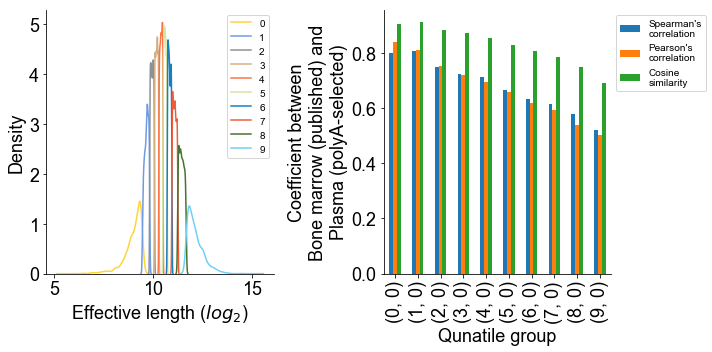

In [4]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(121)


colors = simpsons_palette()
for col, (gl, gl_df) in zip(colors, merged_df.groupby('ntile')):
    sns.distplot(np.log2(gl_df['eff_length']), 
                 ax = ax, 
                 color = col,
                 label = gl,
                hist=False)
ax.set_xlabel('Effective length ($log_2$)')
ax.set_ylabel('Density')




ax = fig.add_subplot(122)
qcut_df.plot.bar(ax = ax)
ax.legend(bbox_to_anchor = (1,1))#.set_visible(False)
ax.set_xlabel('Qunatile group')
ax.set_ylabel(r"Coefficient"\
    ' between\nBone marrow (published) and\nPlasma (polyA-selected)')
sns.despine()
fig.tight_layout()
fig.savefig(figure_path + '/salmon_similarity.pdf')

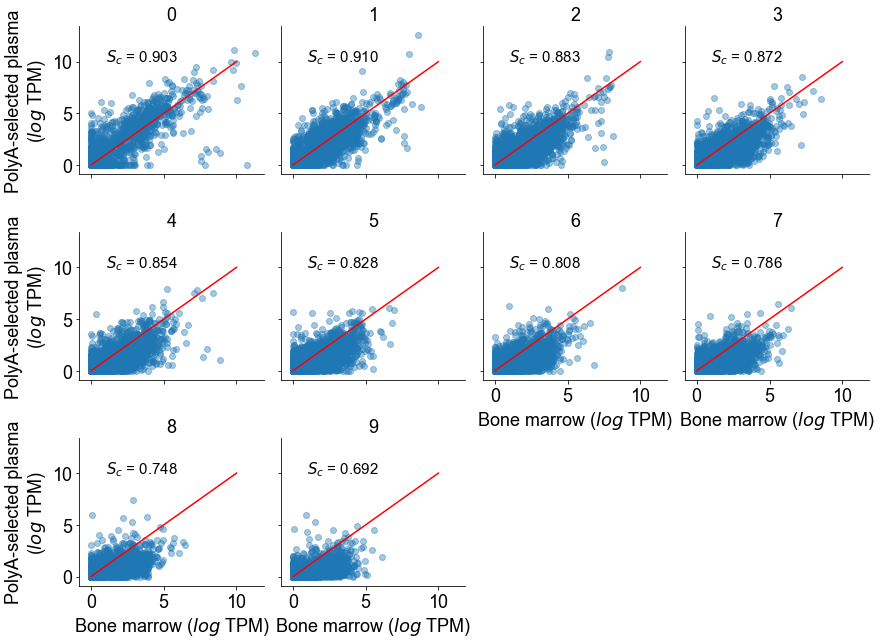

In [5]:
from scipy.stats import pearsonr

plot_qcut = merged_df\
                      .assign(plasma = lambda d: d['Poly(A)-selected'].transform(lambda x: np.log(x+1)))\
                      .assign(bone = lambda d: d['bone marrow'].transform(lambda x: np.log(x+1)))\
                      .sort_values('ntile')
p = sns.FacetGrid(data = plot_qcut, 
                  col = 'ntile', col_wrap = 4)
p.map(plt.scatter, 'bone', 'plasma', alpha=0.4)
p.set_titles('{col_name}')
p.set_axis_labels('Bone marrow ($log$ TPM)', 'PolyA-selected plasma\n($log$ TPM)')

for ax in p.fig.axes:
    ax.plot([0,10],[0,10], color='red')
    
    data = plot_qcut.query("ntile == '%s'" %(ax.title.get_text()))
    cor_coef  = cosine_similarity(data['plasma'].values.reshape(1, -1), 
                                  data['bone'].values.reshape(1, -1))
    ax.text(1, 10, '$S_c$ = %.3f' %cor_coef, fontsize=15)
#ax.set_xscale('log')
#ax.set_yscale('log')
fig.tight_layout()
fig.savefig(figure_path + '/salmon_scatter_similarity.pdf')

In [6]:
gene_df = make_gene_df(tpm_df)
gene_df.head()

prep,gid,gname,Crude,Crude (MNase),DNase I,DNase I + Exo I,DNase I - 3'P,EV,EV (MNase),Fragmented,High salt (450mM),Poly(A)-selected,RNP,RNP (MNase),gene_label,top,color
0,ENSG00000000003.14_2,TSPAN6,0.0,0.0,16.009017,7.556066,27.367033,0.0,0.0,22.611559,0.0,0.775554,0.0,0.0,Others,not_top,grey
1,ENSG00000000005.5_2,TNMD,0.0,0.0,0.000000,181.782994,0.000000,0.0,0.0,17.041759,0.0,0.932300,0.0,0.0,Others,not_top,grey
2,ENSG00000000419.12_2,DPM1,0.0,0.0,0.000000,0.000000,39.206677,0.0,0.0,16.215960,0.0,19.266390,0.0,0.0,Others,not_top,grey
3,ENSG00000000457.13_3,SCYL3,0.0,0.0,10.541942,0.000000,27.303383,0.0,0.0,9.491856,0.0,0.322606,0.0,0.0,Others,not_top,grey
4,ENSG00000000460.16_5,C1orf112,0.0,0.0,0.000000,17.782966,4.763467,0.0,0.0,8.238060,0.0,3.741685,0.0,0.0,Others,not_top,grey


/stor/work/Lambowitz/cdw2854/src/miniconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


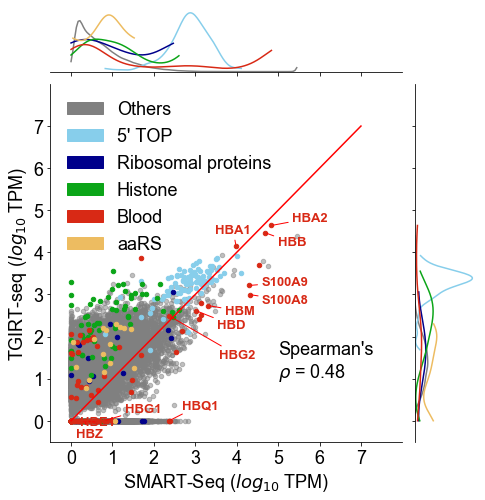

In [7]:
xn = 'Poly(A)-selected'
yn = 'DNase I'
#xn = 'DNase I + Phosphatase'
p = sns.JointGrid(data = gene_df, 
                  x = xn, 
                  y = yn, height=7)
plot_scatter_kallisto(gene_df, xn, yn, 
                      p.ax_joint, 
                      marginal_ax=(p.ax_marg_x, p.ax_marg_y),
                     gene_label=True)
p.ax_marg_y.legend().set_visible(False)
p.ax_marg_x.legend().set_visible(False)
p.ax_joint.set_xlabel('SMART-Seq ($log_{10}$ TPM)')
p.ax_joint.set_ylabel('TGIRT-seq ($log_{10}$ TPM)')
p.savefig(figure_path + '/kallisto_protein_scatter.pdf', bbox_inches='tight')
p.savefig(figure_path + '/kallist_protein_scatter.png', bbox_inches='tight')

In [8]:
gene_df.pipe(lambda d: d[d.gname.str.contains('^HB[A-Z]$|^HB[A-Z][0-9]+$')]).sort_values('DNase I')

prep,gid,gname,Crude,Crude (MNase),DNase I,DNase I + Exo I,DNase I - 3'P,EV,EV (MNase),Fragmented,High salt (450mM),Poly(A)-selected,RNP,RNP (MNase),gene_label,top,color
1687,ENSG00000086506.2_2,HBQ1,0.000000,0.000000,0.000000,157.008328,5.882533,0.000000,0.000000,8.004560,0.000000,232.966500,0.000000,0.000000,Blood,not_top,#d82915
6232,ENSG00000130656.4_3,HBZ,0.000000,0.000000,0.000000,19.011533,0.000000,0.000000,0.000000,3.400780,0.000000,1.121752,0.000000,0.000000,Blood,not_top,#d82915
17806,ENSG00000213931.6_4,HBE1,0.000000,0.000000,0.000000,0.000000,36.550333,0.000000,0.000000,0.000000,0.000000,0.602275,0.000000,0.000000,Blood,not_top,#d82915
17807,ENSG00000213934.7_3,HBG1,0.000000,0.000000,0.000000,0.000000,4.697700,0.000000,0.000000,20.048999,0.000000,5.254695,0.000000,0.000000,Blood,not_top,#d82915
3185,ENSG00000105856.13_5,HBP1,0.000000,0.000000,23.444334,176.516994,43.820533,0.000000,0.000000,47.473856,630.999998,9.298186,0.000000,0.000000,Others,not_top,grey
16361,ENSG00000196565.14_4,HBG2,394.459850,0.000000,309.976088,317.420323,21.649800,0.000000,0.000000,70.528678,0.000000,230.363357,0.000000,0.000000,Blood,not_top,#d82915
18115,ENSG00000223609.8_3,HBD,189.190928,2365.478280,405.615423,158.664995,317.714633,0.000000,2686.439922,257.651072,406.969999,1064.959698,0.000000,1733.619149,Blood,not_top,#d82915
17620,ENSG00000206177.6_3,HBM,206.221922,0.000000,542.553842,466.232652,113.086933,2204.469494,0.000000,160.379995,0.000000,2067.283952,0.000000,540.277735,Blood,not_top,#d82915
17619,ENSG00000206172.8_2,HBA1,154491.401229,173041.874212,14308.471096,9332.119708,3813.657035,21256.995118,34616.799001,2701.327610,16885.353274,9597.748736,12820.825415,134758.633826,Blood,not_top,#d82915
18733,ENSG00000244734.4_3,HBB,172607.904337,184410.255948,29167.027152,17160.032797,9151.486989,31774.292702,40056.098844,13558.490885,19264.766599,48680.032403,13690.130444,164597.319174,Blood,not_top,#d82915


In [9]:
gene_df\
    .pipe(lambda d: d[(d['DNase I'] < 0.5) & (d['Poly(A)-selected'] > 2)])\
    .sort_values('Poly(A)-selected', ascending=False)

prep,gid,gname,Crude,Crude (MNase),DNase I,DNase I + Exo I,DNase I - 3'P,EV,EV (MNase),Fragmented,High salt (450mM),Poly(A)-selected,RNP,RNP (MNase),gene_label,top,color
15458,ENSG00000185885.15_3,IFITM1,0.000000,0.000000,0.0,1941.710273,254.315733,0.0,0.0,337.301930,0.000000,668.674426,0.000000,0.000000,Others,not_top,grey
14654,ENSG00000182117.5_2,NOP10,0.000000,0.000000,0.0,104.723930,76.286100,0.0,0.0,71.007238,0.000000,573.437099,0.000000,0.000000,Others,not_top,grey
6054,ENSG00000129235.10_2,TXNDC17,346.096868,0.000000,0.0,691.555978,133.604830,0.0,0.0,34.234455,0.000000,421.690241,0.000000,0.000000,Others,not_top,grey
6266,ENSG00000130770.17_2,ATPIF1,0.000000,0.000000,0.0,154.085662,87.124593,0.0,0.0,20.014325,0.000000,362.482393,0.000000,0.000000,Others,not_top,grey
4200,ENSG00000113811.10_3,RP11-884K10.5,0.000000,0.000000,0.0,0.000000,71.549700,0.0,0.0,90.002857,0.000000,327.083147,0.000000,0.000000,Others,not_top,grey
13285,ENSG00000173436.13_3,MINOS1,0.000000,0.000000,0.0,152.577329,49.143472,0.0,0.0,137.278306,0.000000,323.427893,0.000000,1194.549413,Others,not_top,grey
16079,ENSG00000188820.12_2,FAM26F,0.000000,0.000000,0.0,26.637233,31.350767,0.0,0.0,47.316159,0.000000,305.736712,0.000000,0.000000,Others,not_top,grey
10802,ENSG00000163221.8_2,S100A12,0.000000,0.000000,0.0,0.000000,37.092667,0.0,0.0,30.963719,0.000000,247.326500,0.000000,0.000000,Blood,not_top,#d82915
8215,ENSG00000143110.11_2,C1orf162,0.000000,0.000000,0.0,43.064999,4.578000,0.0,0.0,19.151741,37.745333,240.537075,0.000000,0.000000,Others,not_top,grey
13683,ENSG00000175768.12_3,TOMM5,0.000000,0.000000,0.0,27.040866,1.203150,0.0,0.0,52.810698,0.000000,234.173787,0.000000,0.000000,Others,not_top,grey


/stor/home/cdw2854/cfNA/plots/kallisto_plots.py:56: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  expr_df = pd.read_table(gene_expr) \


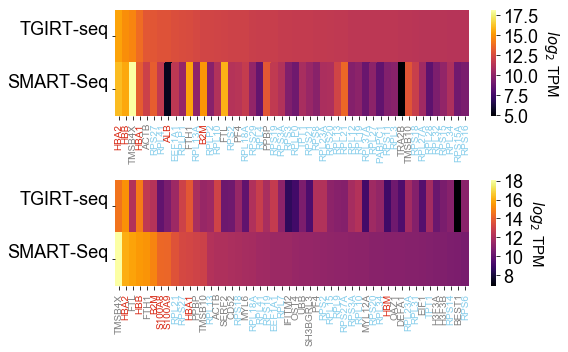

In [10]:
fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot(211)
plot_heatmap(tpm_df, ax , 'DNase I', selected='Poly|DNase I$', colored=True)
#ge.show_legend(ax, bbox_to_anchor = (-0.4,0.7), fontsize=15)
ax.set_ylabel('')
ax.set_xlabel('')

ax = fig.add_subplot(212)
plot_heatmap(tpm_df, ax , 'Poly(A)-selected', selected='Poly|DNase I$', colored=True)
ax.set_ylabel('')
ax.set_xlabel('')
#ax.legend().set_visible(False)
fig.tight_layout()
fig.savefig(figure_path + '/kallisto_heatmap.pdf', bbox_inches ='tight')

In [11]:
def read_platelet():
    d = '/stor/work/Lambowitz/cdw2854/cfNA/platelets/kallisto/platelets_tpm.feather'
    return pd.read_feather(d) \
        .rename(columns ={'tpm':'platelet'}) 
    
gene_expr = '/stor/work/Lambowitz/cdw2854/EV_polyA/published_expr/rna_tissue.tsv'
expr_df = pd.read_table(gene_expr) \
    .pipe(pd.pivot_table, index=['Gene','Gene name'],columns="Sample", values='Value')\
    .reset_index()\
    .merge(read_platelet(), on = 'Gene') 
expr_df.head()

/stor/work/Lambowitz/cdw2854/src/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  import sys
/stor/work/Lambowitz/cdw2854/src/miniconda3/lib/python3.6/site-packages/pandas/io/feather_format.py:124: FutureWarning: `nthreads` argument is deprecated, pass `use_threads` instead
  nthreads=int_use_threads)
/stor/work/Lambowitz/cdw2854/src/miniconda3/lib/python3.6/site-packages/pyarrow/pandas_compat.py:751: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  labels, = index.labels


,Gene,Gene name,adipose tissue,adrenal gland,appendix,bone marrow,breast,cerebral cortex,"cervix, uterine",colon,...,skin,small intestine,smooth muscle,spleen,stomach,testis,thyroid gland,tonsil,urinary bladder,platelet
0,ENSG00000000003,TSPAN6,31.5,26.4,9.2,0.7,53.4,18.5,54.2,48.5,...,7.8,18.8,18.3,14.3,21.2,84.7,53.2,10.2,55.3,0.319667
1,ENSG00000000005,TNMD,10.1,0.2,0.7,0.0,4.3,0.0,0.8,0.7,...,0.3,0.1,0.9,0.2,0.0,0.3,0.1,0.1,0.2,0.000000
2,ENSG00000000419,DPM1,45.6,69.7,46.0,36.3,52.3,37.0,46.9,37.7,...,40.5,43.1,54.2,50.3,34.6,73.3,80.5,48.0,48.8,0.833860
3,ENSG00000000457,SCYL3,5.7,7.7,9.9,2.6,13.7,6.9,10.2,7.7,...,9.2,7.6,9.2,10.4,7.3,12.3,12.8,9.0,9.2,0.288922
4,ENSG00000000460,C1orf112,2.0,1.6,4.5,5.9,3.6,1.7,3.4,2.6,...,2.9,2.0,4.2,3.9,1.8,18.6,2.9,7.3,3.6,3.331232


In [12]:
selected_sample = ['DNase I', 'Poly(A)-selected']
col = selected_sample
col.append('Gene')
cor_df = tpm_df \
    .assign(Gene = lambda d: d.gid.str.split('.', expand=True).iloc[:,0])\
    .filter(col) \
    .merge(expr_df, on ='Gene')\
    .drop(['Gene'], axis=1) \
    .corr(method='spearman') \
    .drop(selected_sample[:-1], axis=0)\
    .filter(selected_sample[:-1]) \
    .sort_values(selected_sample[1], ascending=False)

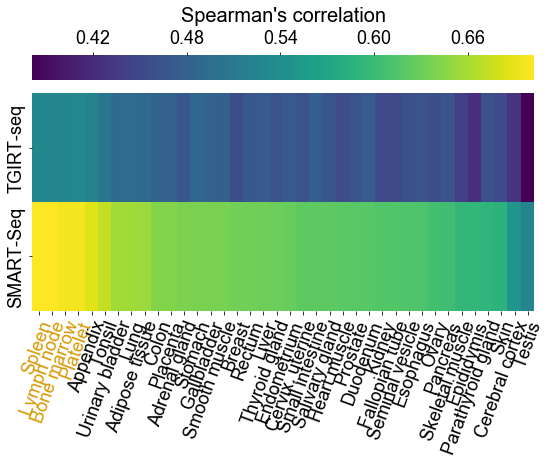

In [13]:
fig = plt.figure(figsize= (9,5))
ax = fig.add_subplot(111)
p = sns.heatmap(cor_df\
                .transpose()\
                .rename(index={'DNase I':'TGIRT-seq','Poly(A)-selected':'SMART-Seq'}), 
            ax = ax, cmap = 'viridis',
            cbar_kws = dict(use_gridspec=False,location="top"))
p.collections[0].colorbar.set_label("Spearman's correlation", 
                                    rotation = 0, va = 'bottom', fontsize=20)
yt = ax.set_xticks(np.arange(cor_df.shape[0])+0.5)
yt = ax.set_xticklabels(cor_df.index.str.capitalize().tolist(), rotation = 70, rotation_mode = 'anchor', ha ='right')
for yt in ax.get_xticklabels():
    if re.search('one marrow|ymph node|pleen|latelet', yt.get_text()):
        yt.set_color('#d89904')
    else:
        yt.set_color('black')
ax.set_yticks([0.5,1.5])
yt = ax.set_yticklabels(ax.get_yticklabels(), va='center')
fig.savefig(figure_path + '/kallisto_tissue_cor.png', bbox_inches='tight')
fig.savefig(figure_path + '/kallisto_tissue_cor.pdf', bbox_inches='tight')

In [14]:
tpm_df\
    .pipe(lambda d: d[d.gname.str.contains('ARS$')])\
    .filter(['gname','DNase I', 'Poly(A)-selected']) \
    .sort_values('Poly(A)-selected', ascending=False) \
    .to_csv('/stor/home/cdw2854/plasma_aaRS.csv', index=False)

In [15]:
gene_df

prep,gid,gname,Crude,Crude (MNase),DNase I,DNase I + Exo I,DNase I - 3'P,EV,EV (MNase),Fragmented,High salt (450mM),Poly(A)-selected,RNP,RNP (MNase),gene_label,top,color
0,ENSG00000000003.14_2,TSPAN6,0.000000,0.000000,16.009017,7.556066,27.367033,0.000000,0.000000,22.611559,0.000000,0.775554,0.000000,0.000000,Others,not_top,grey
1,ENSG00000000005.5_2,TNMD,0.000000,0.000000,0.000000,181.782994,0.000000,0.000000,0.000000,17.041759,0.000000,0.932300,0.000000,0.000000,Others,not_top,grey
2,ENSG00000000419.12_2,DPM1,0.000000,0.000000,0.000000,0.000000,39.206677,0.000000,0.000000,16.215960,0.000000,19.266390,0.000000,0.000000,Others,not_top,grey
3,ENSG00000000457.13_3,SCYL3,0.000000,0.000000,10.541942,0.000000,27.303383,0.000000,0.000000,9.491856,0.000000,0.322606,0.000000,0.000000,Others,not_top,grey
4,ENSG00000000460.16_5,C1orf112,0.000000,0.000000,0.000000,17.782966,4.763467,0.000000,0.000000,8.238060,0.000000,3.741685,0.000000,0.000000,Others,not_top,grey
5,ENSG00000000938.12_2,FGR,0.000000,0.000000,56.871018,116.835696,156.423900,0.000000,0.000000,52.923964,0.000000,13.575061,0.000000,0.000000,Blood,not_top,#d82915
6,ENSG00000000971.15_2,CFH,0.000000,0.000000,0.000000,17.668966,18.214003,0.000000,0.000000,18.264447,0.000000,0.322449,0.000000,0.000000,Others,not_top,grey
7,ENSG00000001036.13_2,FUCA2,0.000000,0.000000,15.092334,0.000000,10.542017,0.000000,0.000000,26.382081,0.000000,6.491970,0.000000,0.000000,Others,not_top,grey
8,ENSG00000001084.11_4,GCLC,0.000000,0.000000,4.087492,0.000000,158.638890,0.000000,0.000000,22.147144,0.000000,5.379789,79.993403,0.000000,Others,not_top,grey
9,ENSG00000001167.14_3,NFYA,0.000000,0.000000,25.573500,0.000000,2.554557,0.000000,0.000000,8.442297,0.000000,0.000000,0.000000,0.000000,Others,not_top,grey


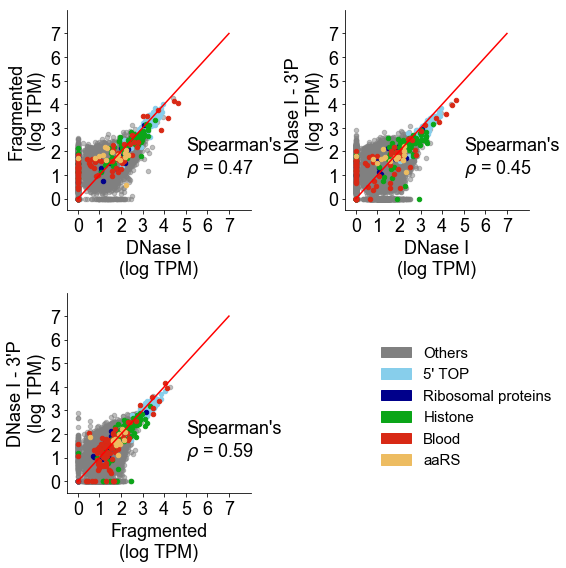

In [16]:
fig = plt.figure(figsize = (8,8))

for i, (xv, yv) in enumerate([('DNase I', 'Fragmented'), 
                            ('DNase I',"DNase I - 3'P"),
                             ('Fragmented', "DNase I - 3'P")]):
    ax = fig.add_subplot(2,2,i+1)  
    plot_scatter_kallisto(gene_df, xv, yv, ax)
    ax.set_xlabel(xv + '\n(log TPM)')
    ax.set_ylabel(yv + '\n(log TPM)')
sns.despine()
ax = plt.subplot(224)
gene_encoder.show_legend(ax, bbox_to_anchor = (1.2,0.8), fontsize=15, frameon=False)
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
ax.set_frame_on(False)
fig.tight_layout()
fig.savefig(figure_path + '/kallisto_tgirt.png', bbox_inches='tight')

/stor/work/Lambowitz/cdw2854/src/miniconda3/lib/python3.6/site-packages/sequencing_tools-0.1-py3.6-linux-x86_64.egg/sequencing_tools/viz_tools/__init__.py:238: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  metric_tables = {os.path.basename(met):pd.read_table(met, skiprows=10) for met in metrics}


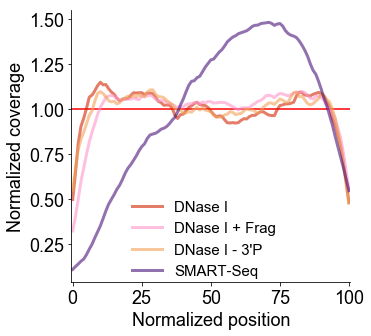

In [17]:
from sequencing_tools.viz_tools import RNA_cov_from_picard
metrics = glob.glob('/stor/work/Lambowitz/cdw2854/cfNA/tgirt_map/kallisto_protein_result/bam_files/picard/*.RNAseq_metrics')
cov_df = RNA_cov_from_picard(metrics) \
    .assign(lab = lambda d: d.samplename.map(label_prep))
    

fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111)

for color, prep in zip(['#d12604', '#ff96cb', '#f2a157','#49127a'],
                      prep_order):
    plot_df = cov_df.query('lab == "%s"' %prep)
    ax.plot(plot_df['normalized_position'],
           plot_df['All_Reads.normalized_coverage'],
           color = color,
           label = prep,
           linewidth = 3, alpha=0.6)
ax.hlines(xmin = -5, xmax = 1000, color = 'red', y = 1)
ax.legend(title = '', fontsize=15, 
          bbox_to_anchor = (0.17,0.35), 
          frameon=False)
ax.set_xlim(-0.5,100.5)
ax.set_xlabel('Normalized position')
ax.set_ylabel('Normalized coverage')
sns.despine()
fig.savefig(figure_path + '/kallisto_coverage_plot.pdf', bbox_inches='tight')

In [18]:
EV_df = tpm_df \
    .filter(regex='DNase\ I$|RNP|EV|gid|gname') \
    .pipe(pd.melt, id_vars = ['gid','gname','DNase I'],
         var_name = 'prep',
         value_name = 'EV_count') \
    .assign(log_dnase = lambda d: np.log(1+d['DNase I']))\
    .assign(log_EV = lambda d: np.log(1+d['EV_count']))\
    .assign(gene_label = lambda d: d.gname.map(label_gene))\
    .assign(gene_label = lambda d: np.where(d.gname.isin(TOP_RNA), "5' TOP", d.gene_label))\
    .assign(color = lambda d: d.gene_label.map(gene_encoder.encoder)) \
    .assign(prep  = lambda d: np.where(d.prep.str.contains('MNase'),
                                      d.prep.str.replace('MNase ','') + ' + MNase',
                                      d.prep))\
    .assign(prep  = lambda d: d.prep.str.replace('EV\+RNP|RNP\+EV','Crude'))\
    .query('EV_count > 0')
EV_df.head()

,gid,gname,DNase I,prep,EV_count,log_dnase,log_EV,gene_label,color
15,ENSG00000001626.14_3,CFTR,35.785542,EV,12379.197157,3.605105,9.423853,Others,grey
29,ENSG00000002834.17_3,LASP1,234.680236,EV,389.616911,5.462476,5.967727,Others,grey
68,ENSG00000004939.14_3,SLC4A1,291.508870,EV,1280.569706,5.678495,7.155841,Others,grey
110,ENSG00000005889.15_3,ZFX,18.892973,EV,240.111945,2.990367,5.485261,Others,grey
164,ENSG00000007047.14_3,MARK4,0.000000,EV,3400.569219,0.000000,8.131992,Others,grey


/stor/work/Lambowitz/cdw2854/src/miniconda3/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


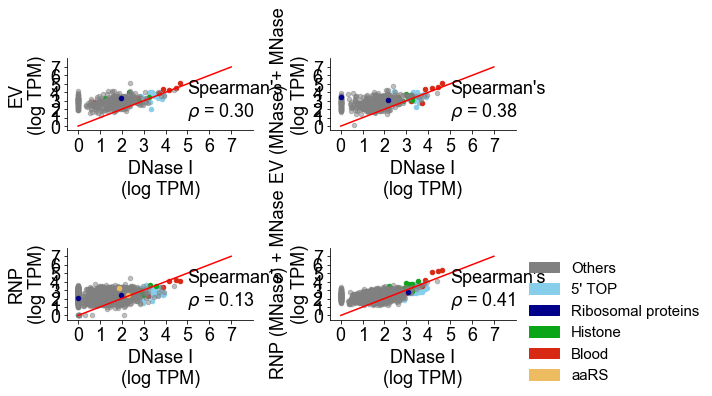

In [19]:
fig = plt.figure(figsize = (10,7))
rmax = 12
for i, (ev, ev_df) in enumerate(EV_df.sort_values('prep').groupby('prep')):
    ax = fig.add_subplot(3,2,i+1)  
    plot_scatter_kallisto(ev_df, 'DNase I', 'EV_count', ax, gene_label=False)
#    for (lab, color), sub_tpm in ev_df.groupby(['gene_lab','color']):
#        alpha = 0.1 if lab == "Others" else 0.8
#        size = 5 if lab =='Others' else 10
#        x = sub_tpm.log_dnase
#        y = sub_tpm.log_EV
#        ax.scatter(x,y, 
#                   color = color, 
#                   alpha=alpha, 
#                   s= size)
#    ax.plot([0,rmax],[0,rmax], color='red')
    ax.set_xlabel('DNase I' + '\n(log TPM)')
    ax.set_ylabel(ev + '\n(log TPM)')

sns.despine()
ax = fig.add_subplot(3,2,4)
#ax.xaxis.set_visible(False)
#ax.yaxis.set_visible(False)
#ax.set_frame_on(False)
gene_encoder.show_legend(ax,  
                        fontsize=15, frameon=False,
                        bbox_to_anchor = (1,1))        
fig.tight_layout()
fig.savefig(figure_path + '/kallisto_EV.png', bbox_inches='tight')

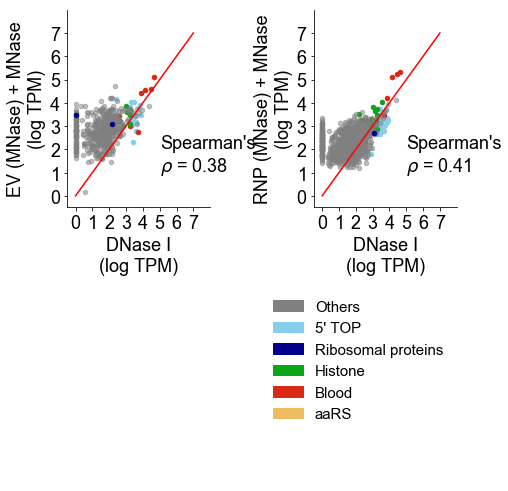

In [20]:
fig = plt.figure(figsize = (7,7))
rmax = 12
for i, (ev, ev_df) in enumerate(EV_df\
                                .pipe(lambda d: d[d.prep.str.contains('MNase')])\
                                .sort_values('prep')\
                                .groupby('prep')):
    ax = fig.add_subplot(2,2,i+1)  
    plot_scatter_kallisto(ev_df, 'DNase I', 'EV_count', ax, gene_label=False)
    ax.set_xlabel('DNase I' + '\n(log TPM)')
    ax.set_ylabel(ev + '\n(log TPM)')

sns.despine()
ax = fig.add_subplot(2,2,4)
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
ax.set_frame_on(False)
gene_encoder.show_legend(ax,  
                        fontsize=15, frameon=False,
                        bbox_to_anchor = (1,1))        
fig.tight_layout()
fig.savefig(figure_path + '/kallisto_mnase_EV.png', bbox_inches='tight')

In [21]:
metrics = glob.glob('/stor/work/Lambowitz/cdw2854/cfNA/tgirt_map/kallisto_protein_result/bam_files/picard/*.RNAseq_metrics')
cov_df = RNA_cov_from_picard(metrics) \
    .assign(lab = lambda d: d.samplename.map(label_prep)) \
    .assign(lab = lambda d: d.lab.str.replace('_kallisto.RNAseq_metrics','')) \
    .pipe(lambda d: d[d.lab.str.contains('RNP|EV|DNase')])\
    .pipe(lambda d: d[d.lab.str.contains('MNase|I$')])

/stor/work/Lambowitz/cdw2854/src/miniconda3/lib/python3.6/site-packages/sequencing_tools-0.1-py3.6-linux-x86_64.egg/sequencing_tools/viz_tools/__init__.py:238: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  metric_tables = {os.path.basename(met):pd.read_table(met, skiprows=10) for met in metrics}


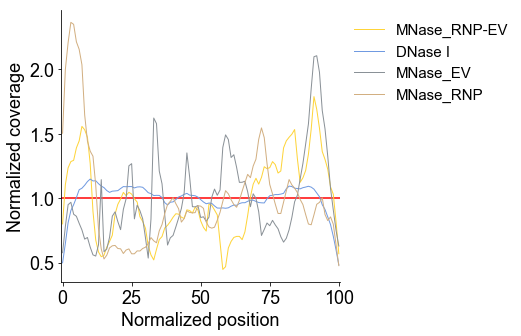

In [22]:
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111)
EV_prep_order = cov_df.lab.unique()
for color, prep in zip(simpsons_palette(),
                      EV_prep_order):
    plot_df = cov_df.query('lab == "%s"' %prep)
    ax.plot(plot_df['normalized_position'],
           plot_df['All_Reads.normalized_coverage'],
           color = color,
           label = prep,
           linewidth = 1, alpha=1)
ax.hlines(xmin = -5, xmax = 1000, color = 'red', y = 1)
ax.legend(title = '', fontsize=15, 
          bbox_to_anchor = (1,1), 
          frameon=False)
ax.set_xlim(-0.5,100.5)
ax.set_xlabel('Normalized position')
ax.set_ylabel('Normalized coverage')
sns.despine()

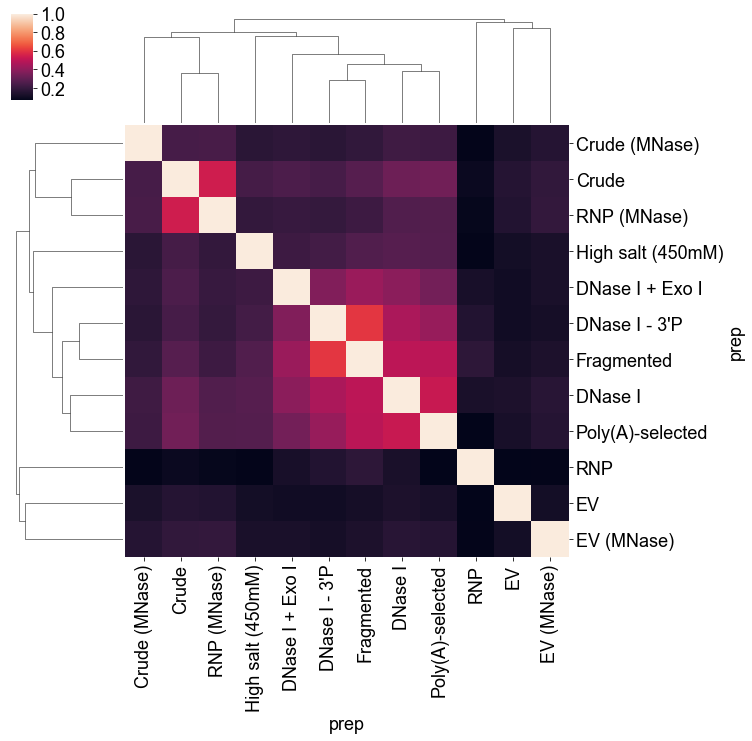

In [23]:
sns.clustermap(tpm_df.iloc[:,2:].transform(lambda x: np.log(x+1)).corr(method='pearson'))